<a href="https://colab.research.google.com/github/NehaSontakk/BATH-Prokka-Comparison/blob/main/Contig_coverage_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparison of Annotation Coverage by BATH and Prokka per Contig

This script is used to evaluate and compare genomic annotations between Prokka and BATH. The BATH data was separated into positive and negative strands, with start and end positions adjusted accordingly. Prokka annotations were filtered to separate hypothetical proteins from annotated ones. To assess the coverage of annotations on contigs, length of sequence covered by annotations for each contig is calculated. These lengths were used to compute the percentage of each contig covered by Prokka annotations, BATH annotations, and hypothetical proteins (Prokka unannotated regions). The coverage of contigs is visualised using bar plots, depicting the percentage of coverage by different annotation sources and the proportion of unannotated regions. Additionally, we calculated and plotted the number of annotations per contig for both Prokka and BATH.

In [1]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 37.1 MB/s eta 0:00:00


In [2]:
#Output files
prokka_annotations_save = '/content/drive/MyDrive/Lab Work/Parkinsons_Data/Iteration_Sep30/Prokka Output/Prokka_proteins.xlsx'
bath_dedup_annotations_save = "/content/drive/MyDrive/Lab Work/Parkinsons_Data/Iteration_Sep30/Deduplication Output/BATH_proteins.xlsx"
#Classifications
bath_prokka_alignment = "/content/drive/MyDrive/Lab Work/Parkinsons_Data/Iteration_Sep30/Aligned Outputs/Aligned_Outputs.xlsx"
#Fasta file
fasta_file = '/content/drive/MyDrive/Lab Work/Parkinsons_Data/Iteration_Sep30/PROKKA_Oct3/unhashed_combined_binned_unbinned.fna'

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import subprocess
import matplotlib.pyplot as plt
from Bio import SeqIO
from glob import glob
from pathlib import Path

In [4]:
prokka_proteins = pd.read_excel(prokka_annotations_save)
venn_data = pd.read_excel(bath_prokka_alignment)
bath_protein = pd.read_excel(bath_dedup_annotations_save)
bath_protein['seq_id'] = bath_protein['target name']
# Separate BATH data into positive and negative strands
pos_strand = bath_protein[bath_protein['strand'] == "+"].copy()
neg_strand = bath_protein[bath_protein['strand'] == "-"].copy()

# Handle columns for positive strand
pos_strand.loc[:, 'start'] = pos_strand['ali from'].astype(int)
pos_strand.loc[:, 'end'] = pos_strand['ali to'].astype(int)

# Handle columns for negative strand
neg_strand.loc[:, 'start'] = neg_strand['ali from flip'].astype(int)
neg_strand.loc[:, 'end'] = neg_strand['ali to flip'].astype(int)

# Filter Prokka proteins into positive and negative strands
prokka_proteins_plus = prokka_proteins[prokka_proteins['strand'] == '+'].copy()
prokka_proteins_minus = prokka_proteins[prokka_proteins['strand'] == '-'].copy()
bath_protein = pd.concat([pos_strand,neg_strand])

#### Area of annotation covered by Prokka

In [5]:
prokka_proteins.columns

Index(['seq_id', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase',
       'attributes', 'ID', 'Name', 'db_xref', 'eC_number', 'gene', 'inference',
       'locus_tag', 'note', 'product', 'coverage interval', 'bin status'],
      dtype='object')

In [6]:
# Setup and Reading FASTA File
def read_fasta(file_path):
    contigs_list = []
    with open(file_path, "r") as handle:
        for record in SeqIO.parse(handle, "fasta"):
            contigs_list.append({'seq_id': record.id, 'length': len(record.seq)})
    return pd.DataFrame(contigs_list)

contigs_info = read_fasta(fasta_file)

# Filter Prokka proteins
def filter_proteins(proteins_df):
    annotated = proteins_df[proteins_df['product'] != 'hypothetical protein']
    non_annotated = proteins_df[proteins_df['product'] == 'hypothetical protein']
    return annotated, non_annotated

annotated_prokka_proteins, prodigal_orf = filter_proteins(prokka_proteins)

# Separate BATH data into positive and negative strands
def separate_strands(df):
    pos_strand = df[df['strand'] == "+"].copy()
    neg_strand = df[df['strand'] == "-"].copy()
    pos_strand['start'], pos_strand['end'] = pos_strand['ali from'].astype(int), pos_strand['ali to'].astype(int)
    neg_strand['start'], neg_strand['end'] = neg_strand['ali from flip'].astype(int), neg_strand['ali to flip'].astype(int)
    return pd.concat([pos_strand, neg_strand])

bath_protein = separate_strands(bath_protein)
bath_protein['seq_id'] = bath_protein['target name']

# Calculate covered length
def calculate_covered_length(df, seq_id):
    covered_points = set()
    for _, row in df[df['seq_id'] == seq_id].iterrows():
        covered_points.update(range(row['start'], row['end'] + 1))
    return len(covered_points)


In [7]:
coverage_intervals = {
    "1.4-1.6": (1.4, 1.6),
    "1.9-2.1": (1.9, 2.1),
    "2.4-2.6": (2.4, 2.6),
    "3.8-4.2": (3.8, 4.2),
    "7.5-8.5": (7.5, 8.5)
}

# Function to find coverage interval
def get_coverage_interval(coverage):
    for interval, (low, high) in coverage_intervals.items():
        if low <= coverage <= high:
            return interval
    return "Outside defined intervals"

def categorize_row(row):
    # Split the 'target name' once and reuse the parts
    parts = row['seq_id'].split('_')

    # Extract the coverage, with a check if the format is correct
    try:
        coverage = float(parts[5])
    except (IndexError, ValueError):
        raise ValueError(f"Unexpected format in 'target name': {row['target name']}")

    # Initialize bin status
    bin_status = None

    # Check for bin status, accounting for suffixes like '.33'
    last_part = parts[-1]
    if last_part.startswith("bin"):
        bin_status = "binned"
    elif last_part == "unbinned":
        bin_status = "unbinned"
    else:
        bin_status = "unknown"  # Handle unknown cases, if necessary

    # Determine the coverage interval
    interval = get_coverage_interval(coverage)

    return pd.Series([interval, bin_status])

# Apply the function to create new columns
contigs_info[['coverage interval', 'bin status']] = contigs_info.apply(categorize_row, axis=1)

In [8]:
contigs_info['total_prodigal'] = 0
contigs_info['total_covered_prokka'] = 0
contigs_info['total_covered_bath'] = 0
contigs_info['total_uncovered_prokka'] = 0
contigs_info['total_uncovered_bath'] = 0
contigs_info['contig_length'] = 0

for _, contig in contigs_info.iterrows():
    seq_id = contig['seq_id']
    contig_length = contig['length']

    total_prodigal = calculate_covered_length(prodigal_orf, seq_id)
    total_covered_prokka = calculate_covered_length(annotated_prokka_proteins, seq_id)
    total_covered_bath = calculate_covered_length(bath_protein, seq_id)

    contigs_info.loc[contigs_info['seq_id'] == seq_id, 'total_prodigal'] = total_prodigal
    contigs_info.loc[contigs_info['seq_id'] == seq_id, 'total_covered_prokka'] = total_covered_prokka
    contigs_info.loc[contigs_info['seq_id'] == seq_id, 'total_covered_bath'] = total_covered_bath
    contigs_info.loc[contigs_info['seq_id'] == seq_id, 'contig_length'] = contig['length']



In [9]:
# Perform groupby and aggregation with corrected syntax
aggregated_df = contigs_info.groupby(['coverage interval','bin status']).agg({
    'seq_id': 'count',  # Count the number of entries per 'coverage interval'
    'total_prodigal': 'sum',  # Sum of 'total_prodigal'
    'total_covered_prokka': 'sum',  # Sum of 'total_covered_prokka'
    'total_covered_bath': 'sum',  # Sum of 'total_covered_bath'
    'contig_length': 'sum'  # Sum of 'contig_length'
})

# Display the aggregated DataFrame
print(aggregated_df)

                              seq_id  total_prodigal  total_covered_prokka  \
coverage interval bin status                                                 
1.4-1.6           binned        7163         3347139               2077789   
                  unbinned        96           23290                 16428   
1.9-2.1           binned        4166         3690120               3080173   
                  unbinned       166           52298                 23964   
2.4-2.6           binned        2567         4009652               3653053   
                  unbinned       195           55254                 24134   
3.8-4.2           binned         584         4283444               4475723   
                  unbinned        46           13384                  7125   
7.5-8.5           binned          42         3734651               5457230   
                  unbinned         4            1502                   501   

                              total_covered_bath  contig_length

In [10]:
aggregated_df['percent_covered_prokka'] = (aggregated_df['total_covered_prokka'] / aggregated_df['contig_length']) * 100
aggregated_df['percent_covered_prodigal'] = (aggregated_df['total_prodigal'] / aggregated_df['contig_length']) * 100
aggregated_df['percent_uncovered_prokka'] = 100 - aggregated_df['percent_covered_prokka'] - aggregated_df['percent_covered_prodigal']

aggregated_df['percent_covered_bath'] = (aggregated_df['total_covered_bath'] / aggregated_df['contig_length']) * 100
aggregated_df['percent_uncovered_bath'] = 100 - aggregated_df['percent_covered_bath']

In [11]:
aggregated_df

seq_id  total_prodigal  total_covered_prokka  \
coverage interval bin status                                                 
1.4-1.6           binned        7163         3347139               2077789   
                  unbinned        96           23290                 16428   
1.9-2.1           binned        4166         3690120               3080173   
                  unbinned       166           52298                 23964   
2.4-2.6           binned        2567         4009652               3653053   
                  unbinned       195           55254                 24134   
3.8-4.2           binned         584         4283444               4475723   
                  unbinned        46           13384                  7125   
7.5-8.5           binned          42         3734651               5457230   
                  unbinned         4            1502                   501   

                              total_covered_bath  contig_length  \
coverage interval bin status                                      
1.4-1.6           binned                 4012457       10001045   
                  unbinned                 37541          96000   
1.9-2.1           binned                 4168874       10001649   
                  unbinned                 62108         166000   
2.4-2.6           binned                 4263993       10002519   
                  unbinned                 74643         195000   
3.8-4.2           binned                 4415752       10003873   
                  unbinned                 18939          46000   
7.5-8.5           binned                 5267162       10169223   
                  unbinned                  1695           4000   

                              percent_covered_prokka  \
coverage interval bin status                           
1.4-1.6           binned                   20.775719   
                  unbinned                 17.112500   
1.9-2.1           binned                   30.796652   
                  unbinned                 14.436145   
2.4-2.6           binned                   36.521330   
                  unbinned                 12.376410   
3.8-4.2           binned                   44.739902   
                  unbinned                 15.489130   
7.5-8.5           binned                   53.664179   
                  unbinned                 12.525000   

                              percent_covered_prodigal  \
coverage interval bin status                             
1.4-1.6           binned                     33.467893   
                  unbinned                   24.260417   
1.9-2.1           binned                     36.895116   
                  unbinned                   31.504819   
2.4-2.6           binned                     40.086422   
                  unbinned                   28.335385   
3.8-4.2           binned                     42.817857   
                  unbinned                   29.095652   
7.5-8.5           binned                     36.725038   
                  unbinned                   37.550000   

                              percent_uncovered_prokka  percent_covered_bath  \
coverage interval bin status                                                   
1.4-1.6           binned                     45.756388             40.120377   
                  unbinned                   58.627083             39.105208   
1.9-2.1           binned                     32.308232             41.681867   
                  unbinned                   54.059036             37.414458   
2.4-2.6           binned                     23.392247             42.629192   
                  unbinned                   59.288205             38.278462   
3.8-4.2           binned                     12.442241             44.140424   
                  unbinned                   55.415217             41.171739   
7.5-8.5           binned                      9.610783             51.795127   
                  unbinned            

## How much of the contig is covered by BATH vs Prokka?

In [12]:
aggregated_df

seq_id  total_prodigal  total_covered_prokka  \
coverage interval bin status                                                 
1.4-1.6           binned        7163         3347139               2077789   
                  unbinned        96           23290                 16428   
1.9-2.1           binned        4166         3690120               3080173   
                  unbinned       166           52298                 23964   
2.4-2.6           binned        2567         4009652               3653053   
                  unbinned       195           55254                 24134   
3.8-4.2           binned         584         4283444               4475723   
                  unbinned        46           13384                  7125   
7.5-8.5           binned          42         3734651               5457230   
                  unbinned         4            1502                   501   

                              total_covered_bath  contig_length  \
coverage interval bin status                                      
1.4-1.6           binned                 4012457       10001045   
                  unbinned                 37541          96000   
1.9-2.1           binned                 4168874       10001649   
                  unbinned                 62108         166000   
2.4-2.6           binned                 4263993       10002519   
                  unbinned                 74643         195000   
3.8-4.2           binned                 4415752       10003873   
                  unbinned                 18939          46000   
7.5-8.5           binned                 5267162       10169223   
                  unbinned                  1695           4000   

                              percent_covered_prokka  \
coverage interval bin status                           
1.4-1.6           binned                   20.775719   
                  unbinned                 17.112500   
1.9-2.1           binned                   30.796652   
                  unbinned                 14.436145   
2.4-2.6           binned                   36.521330   
                  unbinned                 12.376410   
3.8-4.2           binned                   44.739902   
                  unbinned                 15.489130   
7.5-8.5           binned                   53.664179   
                  unbinned                 12.525000   

                              percent_covered_prodigal  \
coverage interval bin status                             
1.4-1.6           binned                     33.467893   
                  unbinned                   24.260417   
1.9-2.1           binned                     36.895116   
                  unbinned                   31.504819   
2.4-2.6           binned                     40.086422   
                  unbinned                   28.335385   
3.8-4.2           binned                     42.817857   
                  unbinned                   29.095652   
7.5-8.5           binned                     36.725038   
                  unbinned                   37.550000   

                              percent_uncovered_prokka  percent_covered_bath  \
coverage interval bin status                                                   
1.4-1.6           binned                     45.756388             40.120377   
                  unbinned                   58.627083             39.105208   
1.9-2.1           binned                     32.308232             41.681867   
                  unbinned                   54.059036             37.414458   
2.4-2.6           binned                     23.392247             42.629192   
                  unbinned                   59.288205             38.278462   
3.8-4.2           binned                     12.442241             44.140424   
                  unbinned                   55.415217             41.171739   
7.5-8.5           binned                      9.610783             51.795127   
                  unbinned            

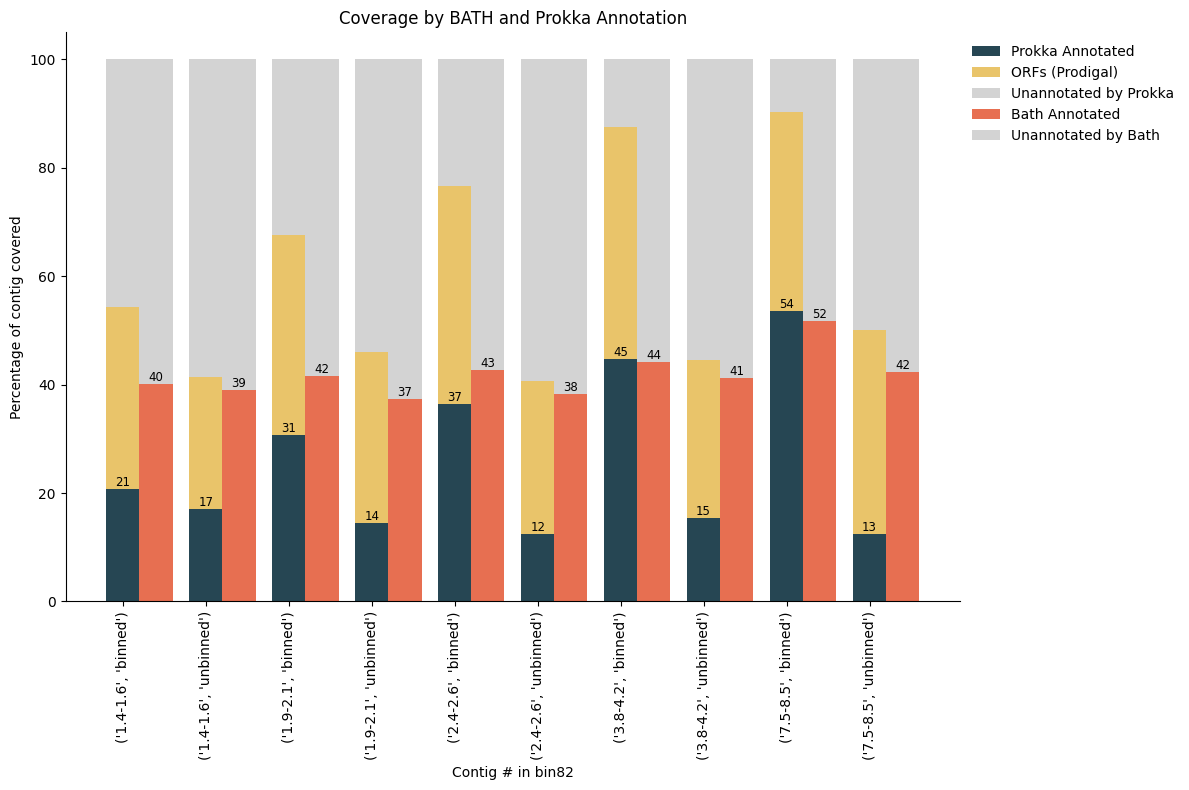

In [13]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(12, 8))
n_contigs = len(aggregated_df)
index = range(n_contigs)
bar_width = 0.4

bar2 = ax.bar(index, aggregated_df['percent_covered_prokka'], bar_width, label='Prokka Annotated',color="#264653")
bar1 = ax.bar(index, aggregated_df['percent_covered_prodigal'], bar_width, bottom=aggregated_df['percent_covered_prokka'], label='ORFs (Prodigal)',color='#E9C46A')
bar3 = ax.bar(index, aggregated_df['percent_uncovered_prokka'], bar_width, bottom=aggregated_df['percent_covered_prodigal']+aggregated_df['percent_covered_prokka'], label='Unannotated by Prokka',color='lightgrey')

bar4 = ax.bar([p + bar_width for p in index], aggregated_df['percent_covered_bath'], bar_width, label='Bath Annotated',color="#E76F51")
bar5 = ax.bar([p + bar_width for p in index], aggregated_df['percent_uncovered_bath'], bar_width, bottom=aggregated_df['percent_covered_bath'], label='Unannotated by Bath',color='lightgrey')

for rect in bar2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2.0, height, f'{round(height)}', ha='center', va='bottom',fontsize=8.5)

for rect in bar4:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2.0, height, f'{round(height)}', ha='center', va='bottom',fontsize=8.5)

ax.set_xlabel('Contig # in bin82')
ax.set_ylabel('Percentage of contig covered')
ax.set_title('Coverage by BATH and Prokka Annotation')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)  # Ensure bottom line is visible
ax.spines['left'].set_visible(True)  # Ensure left line is visible
indices = range(n_contigs)
ax.set_xticks(indices)
ax.set_xticklabels(aggregated_df.index, rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.tight_layout()
plt.show()

## How many annotations are generated by BATH vs Prokka?

In [14]:
contigs_info

,seq_id,length,coverage interval,bin status,total_prodigal,total_covered_prokka,total_covered_bath,total_uncovered_prokka,total_uncovered_bath,contig_length
0,NODE_16543_length_5404_cov_2.090484_bin.67,5404,1.9-2.1,binned,3251,0,0,0,0,5404
1,NODE_6422_length_4886_cov_2.073070_bin.13,4886,1.9-2.1,binned,3218,618,636,0,0,4886
2,NODE_19516_length_4530_cov_2.052067_bin.67,4530,1.9-2.1,binned,3504,0,0,0,0,4530
3,NODE_19686_length_4491_cov_2.041479_bin.156,4491,1.9-2.1,binned,3651,0,0,0,0,4491
4,NODE_9473_length_4462_cov_1.960517_bin.17,4462,1.9-2.1,binned,2379,1308,1497,0,0,4462
...,...,...,...,...,...,...,...,...,...,...
15024,NODE_62471_length_1000_cov_2.520635_unbinned,1000,2.4-2.6,unbinned,0,0,363,0,0,1000
15025,NODE_62472_length_1000_cov_2.474074_unbinned,1000,2.4-2.6,unbinned,543,0,0,0,0,1000
15026,NODE_62473_length_1000_cov_2.433862_unbinned,1000,2.4-2.6,unbinned,0,0,531,0,0,1000
15027,NODE_62474_length_1000_cov_2.432804_unbinned,1000,2.4-2.6,unbinned,780,0,801,0,0,1000


In [32]:
def calculate_num_annotations(annotation_df, contig_id):
    annotations = annotation_df[annotation_df['seq_id'] == contig_id]
    return len(annotations)

# Initialize a list to hold results
results = []

for _, contig in contigs_info.iterrows():
    seq_id = contig['seq_id']
    coverage_interval = contig['coverage interval']

    # Calculate number of annotations for Prokka and BATH
    num_annotations_prokka = calculate_num_annotations(annotated_prokka_proteins, seq_id)
    num_annotations_bath = calculate_num_annotations(bath_protein, seq_id)

    results.append({
        'seq_id': seq_id,
        'coverage interval': coverage_interval,
        'Prokka Annotations Count': num_annotations_prokka,
        'BATH Annotations Count': num_annotations_bath
    })

    print(f"Contig {seq_id}: Prokka Annotations = {num_annotations_prokka}, BATH Annotations = {num_annotations_bath}")

# Convert results to DataFrame for easier manipulation and visualization
results_df = pd.DataFrame(results)
print(results_df)

Streaming output truncated to the last 5000 lines.
Contig NODE_31932_length_1386_cov_1.520661_bin.112: Prokka Annotations = 1, BATH Annotations = 2
Contig NODE_57895_length_1386_cov_1.568745_bin.51: Prokka Annotations = 0, BATH Annotations = 0
Contig NODE_57896_length_1386_cov_1.474831_bin.113: Prokka Annotations = 0, BATH Annotations = 0
Contig NODE_34266_length_1386_cov_1.528926_bin.26: Prokka Annotations = 0, BATH Annotations = 0
Contig NODE_29031_length_1386_cov_1.566491_bin.61: Prokka Annotations = 0, BATH Annotations = 0
Contig NODE_27190_length_1386_cov_1.519910_bin.80: Prokka Annotations = 0, BATH Annotations = 0
Contig NODE_23020_length_1386_cov_1.506386_bin.39: Prokka Annotations = 0, BATH Annotations = 0
Contig NODE_23019_length_1386_cov_1.544703_bin.21: Prokka Annotations = 0, BATH Annotations = 0
Contig NODE_35866_length_1385_cov_1.529323_bin.19: Prokka Annotations = 0, BATH Annotations = 1
Contig NODE_13511_length_1385_cov_1.552632_bin.16: Prokka Annotations = 1, BATH Ann

In [15]:
results_df

NameError: name 'results_df' is not defined

In [29]:
# Perform groupby and aggregation with corrected syntax
aggregated_num_df = results_df.groupby(['coverage interval','bin status'])['Prokka Annotations Count', 'BATH Annotations Count'].sum()

# Display the aggregated DataFrame
print(aggregated_num_df)

KeyError: 'coverage interval'

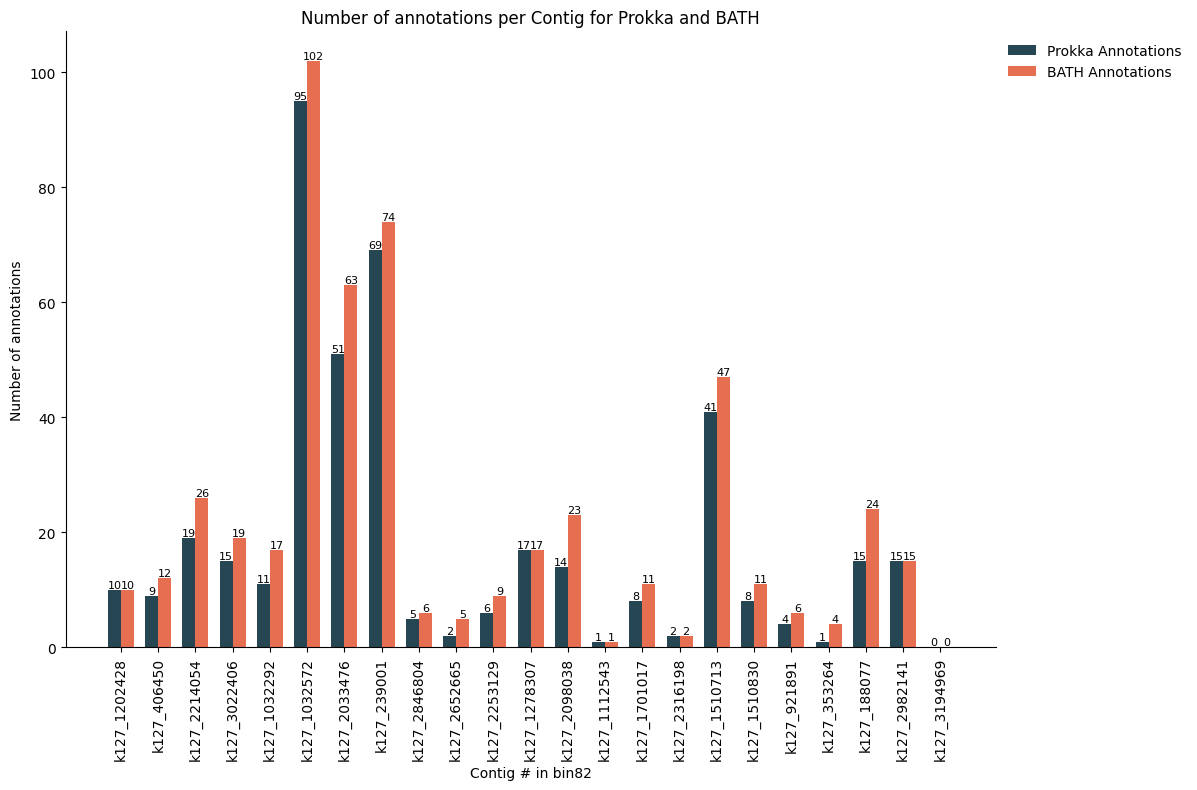

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
n_contigs = len(results_df)
index = range(n_contigs)
bar_width = 0.35

# Creating bars for Prokka annotations
prokka_bars = ax.bar(index, results_df['Prokka Annotations Count'], bar_width, label='Prokka Annotations', color="#264653")

# Creating bars for BATH annotations, offset by bar_width for side-by-side bars
bath_bars = ax.bar([p + bar_width for p in index], results_df['BATH Annotations Count'], bar_width, label='BATH Annotations', color="#E76F51")

# Adding text labels above the bars
for rect in prokka_bars:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2.0, height, '%d' % int(height), ha='center', va='bottom', fontsize=8)

for rect in bath_bars:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2.0, height, '%d' % int(height), ha='center', va='bottom', fontsize=8)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)  # Ensure bottom line is visible
ax.spines['left'].set_visible(True)  # Ensure left line is visible
ax.set_xlabel('Contig # in bin82')
ax.set_ylabel('Number of annotations')
ax.set_title('Number of annotations per Contig for Prokka and BATH')
ax.set_xticks([p + bar_width / 2 for p in index])  # Positioning the tick in the middle of the grouped bars
ax.set_xticklabels(results_df['seq_id'], rotation=90)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.show()


## How much of a contig is covered by BATH compared to Prokka? (Fancier plot)

In [16]:
def calculate_length_and_contig(annotation):
    if pd.isna(annotation):
        return None, None
    parts = annotation.split('\t')
    contig = parts[0]
    start = int(parts[1])
    end = int(parts[2])
    length = abs(end - start)
    return length, contig

# Apply the function to the BATH column
venn_data[['BATH length', 'contig_bath']] = venn_data['BATH'].apply(lambda x: pd.Series(calculate_length_and_contig(x)))

# Apply the function to the Prokka column
venn_data[['Prokka length', 'contig_prokka']] = venn_data['Prokka'].apply(lambda x: pd.Series(calculate_length_and_contig(x)))
# Fill missing values in contig_bath with contig_prokka and vice versa to create a single contig column
venn_data['contig'] = venn_data['contig_bath'].combine_first(venn_data['contig_prokka'])

# Drop the intermediate contig columns
venn_data = venn_data.drop(columns=['contig_bath', 'contig_prokka'])

# Merge with contigs_info to get the full length of each contig
venn_data = venn_data.merge(contigs_info, left_on='contig', right_on='seq_id', how='left').drop(columns=['seq_id'])
venn_data

,Prokka,BATH,label,BATH length,Prokka length,contig,length,coverage interval,bin status,total_prodigal,total_covered_prokka,total_covered_bath,total_uncovered_prokka,total_uncovered_bath,contig_length
0,NODE_29401_length_1940_cov_1.439257_bin.8\t107...,NaN,Prokka Unannotated,NaN,614.0,NODE_29401_length_1940_cov_1.439257_bin.8,1940,1.4-1.6,binned,615,0,1011,0,0,1940
1,NODE_40722_length_2150_cov_2.025776_bin.172\t3...,NaN,Prokka Unannotated,NaN,872.0,NODE_40722_length_2150_cov_2.025776_bin.172,2150,1.9-2.1,binned,873,768,780,0,0,2150
2,NODE_16097_length_1412_cov_1.511422_bin.60\t72...,NaN,Prokka Unannotated,NaN,494.0,NODE_16097_length_1412_cov_1.511422_bin.60,1412,1.4-1.6,binned,909,0,453,0,0,1412
3,NODE_16339_length_2693_cov_2.019333_bin.49\t75...,NaN,Prokka Unannotated,NaN,200.0,NODE_16339_length_2693_cov_2.019333_bin.49,2693,1.9-2.1,binned,1933,0,522,0,0,2693
4,NODE_16339_length_2693_cov_2.019333_bin.49\t33...,NaN,Prokka Unannotated,NaN,176.0,NODE_16339_length_2693_cov_2.019333_bin.49,2693,1.9-2.1,binned,1933,0,522,0,0,2693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31998,NODE_13816_length_2142_cov_2.018687_bin.15\t32...,NODE_13816_length_2142_cov_2.018687_bin.15\t41...,BATH and Prokka Annotated,506.0,644.0,NODE_13816_length_2142_cov_2.018687_bin.15,2142,1.9-2.1,binned,273,645,507,0,0,2142
31999,NODE_17293_length_1193_cov_1.580844_bin.53\t10...,NODE_17293_length_1193_cov_1.580844_bin.53\t5\...,BATH and Prokka Annotated,551.0,458.0,NODE_17293_length_1193_cov_1.580844_bin.53,1193,1.4-1.6,binned,330,459,552,0,0,1193
32000,NODE_3007_length_16594_cov_4.003325_bin.84\t44...,NODE_3007_length_16594_cov_4.003325_bin.84\t44...,BATH and Prokka Annotated,857.0,893.0,NODE_3007_length_16594_cov_4.003325_bin.84,16594,3.8-4.2,binned,4626,9909,10671,0,0,16594
32001,NODE_3007_length_16594_cov_4.003325_bin.84\t14...,NODE_3007_length_16594_cov_4.003325_bin.84\t14...,BATH and Prokka Annotated,722.0,728.0,NODE_3007_length_16594_cov_4.003325_bin.84,16594,3.8-4.2,binned,4626,9909,10671,0,0,16594


In [17]:
len(venn_data['contig'].unique())

9444

In [19]:
# Calculate the sum of lengths grouped by label and contig
grouped_sum = venn_data.groupby(['label', 'coverage interval','bin status'])[['BATH length', 'Prokka length', 'length']].sum().reset_index()
grouped_sum

,label,coverage interval,bin status,BATH length,Prokka length,length
0,BATH,1.4-1.6,binned,769475.0,0.0,2177390
1,BATH,1.4-1.6,unbinned,4652.0,0.0,13000
2,BATH,1.9-2.1,binned,803268.0,0.0,2983273
3,BATH,1.9-2.1,unbinned,8893.0,0.0,23000
4,BATH,2.4-2.6,binned,595020.0,0.0,3149050
5,BATH,2.4-2.6,unbinned,9984.0,0.0,21000
6,BATH,3.8-4.2,binned,127506.0,0.0,2940995
7,BATH,3.8-4.2,unbinned,2355.0,0.0,6000
8,BATH,7.5-8.5,binned,5692.0,0.0,2257080
9,BATH and Prokka Annotated,1.4-1.6,binned,1975668.0,2105139.0,4476219


In [100]:
grouped_sum['max_annotated_length'] = grouped_sum[['BATH length', 'Prokka length']].max(axis=1)

pivot_df = grouped_sum.pivot_table(
    index=["coverage interval", "bin status"],
    columns="label",
    values="max_annotated_length",
    aggfunc="max"
)
pivot_df['total_annotated'] = pivot_df.max(axis=1)
pivot_df.reset_index(inplace=True)

new_df = grouped_sum.groupby(['coverage interval', 'bin status'])['length'].sum().reset_index()

In [101]:
merged_df = pivot_df.merge(new_df, on=["coverage interval", "bin status"], how="left")

In [102]:
merged_df.set_index(["coverage interval", "bin status"], inplace=True)

In [103]:
merged_df.columns

Index(['BATH', 'BATH and Prokka Annotated', 'BATH and Prokka Unannotated',
       'Prokka Annotated', 'Prokka Unannotated', 'total_annotated', 'length'],
      dtype='object')

In [104]:
columns_to_transform = ['BATH', 'BATH and Prokka Annotated', 'BATH and Prokka Unannotated',
                        'Prokka Annotated', 'Prokka Unannotated','total_annotated']
# Calculate the percentages
merged_df[columns_to_transform] = merged_df[columns_to_transform].div(merged_df['length'], axis=0) * 100

# Add a new column to confirm percentage covered
merged_df['percentage_covered'] = merged_df[columns_to_transform].sum(axis=1)


In [105]:
merged_df['Unannotated'] = 100 - merged_df['total_annotated']

In [106]:
merged_df

BATH  BATH and Prokka Annotated  \
coverage interval bin status                                         
1.4-1.6           binned       8.256233                  22.587503   
                  unbinned     8.307143                  30.225000   
1.9-2.1           binned       4.504636                  17.874832   
                  unbinned     9.992135                  28.548315   
2.4-2.6           binned       2.066513                  12.922372   
                  unbinned    11.217978                  28.194382   
3.8-4.2           binned       0.117993                   3.199730   
                  unbinned     7.850000                  24.880000   
7.5-8.5           binned       0.000453                   0.273484   
                  unbinned          NaN                        NaN   

                              BATH and Prokka Unannotated  Prokka Annotated  \
coverage interval bin status                                                  
1.4-1.6           binned                         4.013625          0.135216   
                  unbinned                       2.844643               NaN   
1.9-2.1           binned                         2.866320          0.140960   
                  unbinned                       4.810112               NaN   
2.4-2.6           binned                         2.282545          0.208214   
                  unbinned                       3.958427               NaN   
3.8-4.2           binned                         0.613531          0.068963   
                  unbinned                       1.373333               NaN   
7.5-8.5           binned                         0.040551          0.005025   
                  unbinned                      22.000000               NaN   

                              Prokka Unannotated  total_annotated      length  \
coverage interval bin status                                                    
1.4-1.6           binned                5.378046        22.587503     9319928   
                  unbinned              5.108929        30.225000       56000   
1.9-2.1           binned                5.595925        17.874832    17832028   
                  unbinned              6.042697        28.548315       89000   
2.4-2.6           binned                4.877404        12.922372    28793429   
                  unbinned              5.395506        28.194382       89000   
3.8-4.2           binned                1.931414         3.199730   108062726   
                  unbinned              5.173333        24.880000       30000   
7.5-8.5           binned                0.107197         0.273484  1256506885   
                  unbinned             15.475000        22.000000        4000   

                              percentage_covered  Unannotated  
coverage interval bin status                                   
1.4-1.6           binned               62.958126    77.412497  
                  unbinned             76.710714    69.775000  
1.9-2.1           binned               48.857505    82.125168  
                  unbinned             77.941573    71.451685  
2.4-2.6           binned               35.279421    87.077628  
                  unbinned             76.960674    71.805618  
3.8-4.2           binned                9.131360    96.800270  
                  unbinned             64.156667    75.120000  
7.5-8.5           binned                0.700194    99.726516  
                  unbinned             59.475000    78.000000

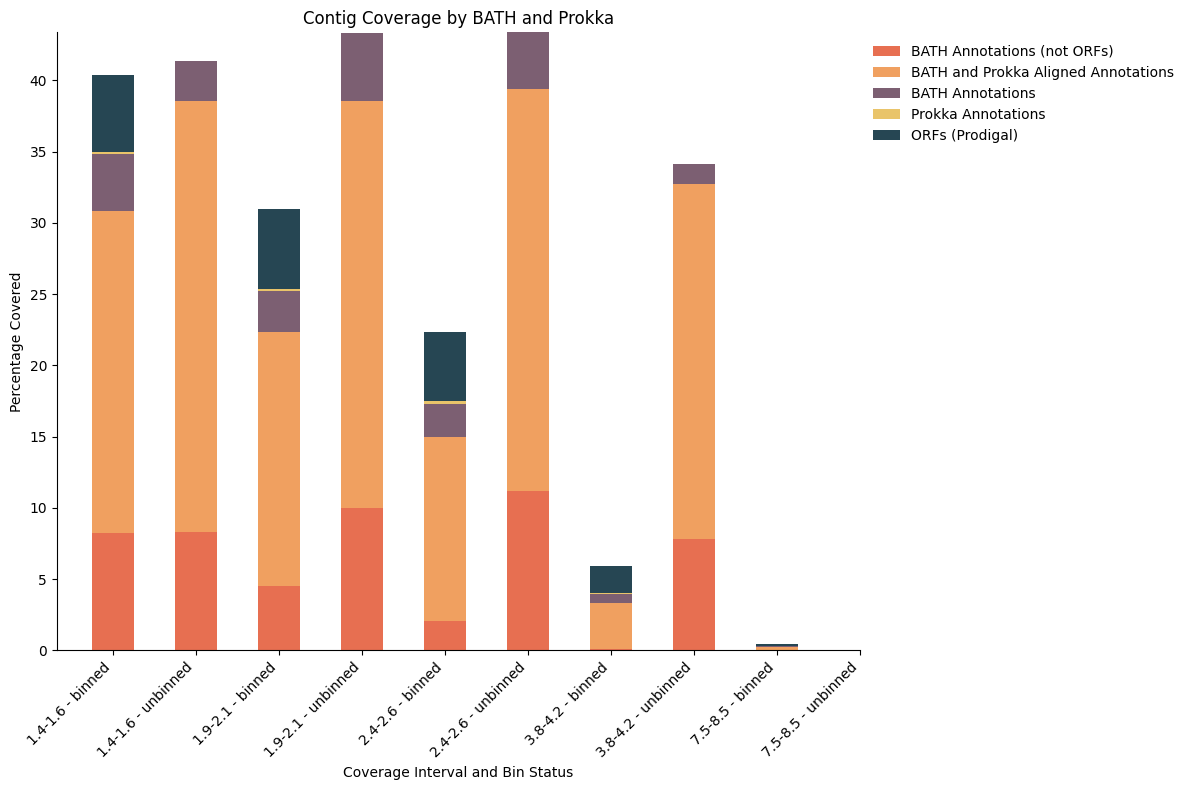

In [107]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `merged_df` is already loaded as shown in your data snippet

plt.style.use('default')

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Define bar positions
bar_width = 0.5
bar_positions = range(len(merged_df))

# Initialize bottoms for stacking bars
bottoms = [0] * len(merged_df)

# Define label order and corresponding colors
label_order = [
    'BATH and Prokka Unannotated',
    'BATH',
    'BATH and Prokka Annotated',
    'Prokka Unannotated',
    'Prokka Annotated',
    'Unannotated'
]

colors = [
    '#E76F51',  # BATH and Prokka Unannotated
    '#f0a060',  # BATH
    '#7C5F72',  # BATH and Prokka Annotated
    '#E9C46A',  # Prokka Unannotated
    '#264653',  # Prokka Annotated
    '#D3D3D3'   # Unannotated
]

custom_labels = {
    'BATH and Prokka Annotated': 'BATH and Prokka Aligned Annotations',
    'Prokka Unannotated': 'ORFs (Prodigal)',
    'BATH and Prokka Unannotated': 'BATH Annotations',
    'BATH': 'BATH Annotations (not ORFs)',
    'Unannotated': 'Unannotated',
    'Prokka Annotated': 'Prokka Annotations'
}

# Rename the columns with custom labels
merged_df = merged_df[
    ['BATH', 'BATH and Prokka Annotated', 'BATH and Prokka Unannotated',
     'Prokka Annotated', 'Prokka Unannotated']
]
merged_df.columns = [custom_labels[label] for label in merged_df.columns]

# Plot each segment
for i, label in enumerate(merged_df.columns):
    ax.bar(
        bar_positions,
        merged_df[label],
        bottom=bottoms,
        width=bar_width,
        label=label,
        color=colors[i]
    )
    # Update bottoms for stacking
    bottoms = [bottoms[j] + merged_df[label].iloc[j] for j in range(len(merged_df))]

# Add visual adjustments
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Coverage Interval and Bin Status')
ax.set_xticks(bar_positions)
ax.set_xticklabels(
    [f"{idx[0]} - {idx[1]}" for idx in merged_df.index],
    rotation=45,
    ha='right'
)
ax.set_ylabel('Percentage Covered')
ax.set_title('Contig Coverage by BATH and Prokka')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

# Show the plot
plt.tight_layout()
plt.show()


## Number of annotations (fancier plot)

<ipython-input-56-4694bdabb1e8>:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bottoms1 = [bottoms1[i] + bar1_data[label][i] for i in range(len(pivot_df))]
<ipython-input-56-4694bdabb1e8>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bottoms2 = [bottoms2[i] + bar2_data[label][i] for i in range(len(pivot_df))]


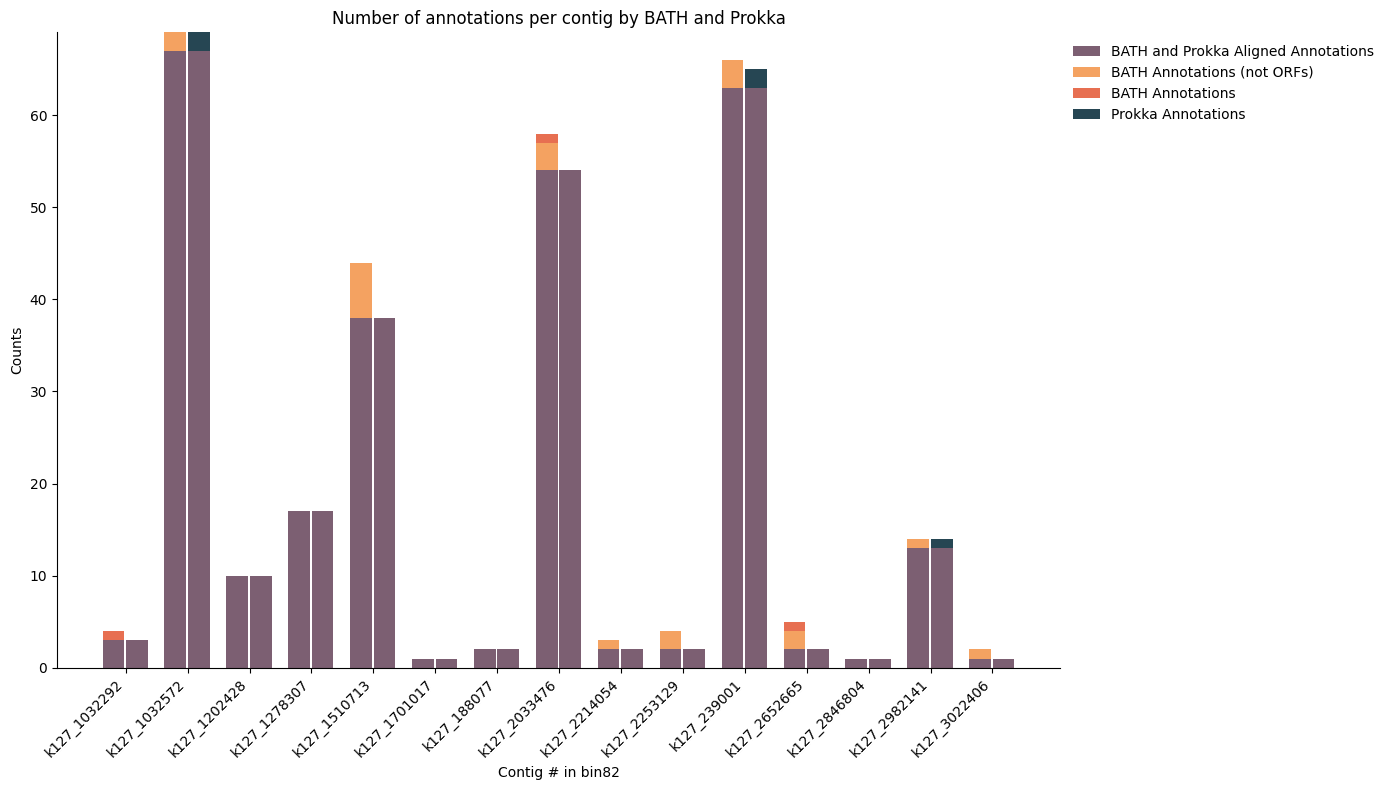

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'venn_data' is already loaded as a DataFrame

# Group the data
grouped_sum = venn_data.groupby(['label', 'contig']).size().reset_index(name='count')

# Create a pivot table
pivot_df = grouped_sum.pivot_table(index='contig', columns='label', values='count', fill_value=0)

# Define the order and colors for the annotations
order_bar1 = ['BATH and Prokka Annotated', 'BATH and Prokka Unannotated', 'BATH']
order_bar2 = ['BATH and Prokka Annotated','Prokka Annotated']

colors = {
    'BATH': '#E76F51',
    'BATH and Prokka Annotated': '#7C5F72',
    'BATH and Prokka Unannotated': '#F4A261',
    'Prokka Annotated': '#264653'
}

custom_labels = {
    'BATH and Prokka Annotated': 'BATH and Prokka Aligned Annotations',
    'Prokka Unannotated': 'ORFs (Prodigal)',
    'BATH and Prokka Unannotated': 'BATH Annotations (not ORFs)',
    'BATH': 'BATH Annotations',
    'Unannotated': 'Unannotated',
    'Prokka Annotated': 'Prokka Annotations'
}

# Separate the data for the two bars
bar1_data = pivot_df[order_bar1]
bar2_data = pivot_df[order_bar2]

# Plot the data as stacked bar charts
fig, ax = plt.subplots(figsize=(14, 8))

# Define the positions for the bars with a small gap between them within each group
bar_width = 0.35
group_width = 1.0  # Width of the space for each group of bars
bar_positions1 = np.arange(len(pivot_df)) * group_width
bar_positions2 = bar_positions1 + bar_width + 0.03  # Adding a small gap between bar 1 and bar 2

# Plot Bar 1
bottoms1 = [0] * len(pivot_df)
for label in order_bar1:
    ax.bar(bar_positions1, bar1_data[label], bottom=bottoms1, width=bar_width, label=custom_labels[label] if custom_labels[label] not in ax.get_legend_handles_labels()[1] else "", color=colors[label])
    bottoms1 = [bottoms1[i] + bar1_data[label][i] for i in range(len(pivot_df))]

# Plot Bar 2
bottoms2 = [0] * len(pivot_df)
for label in order_bar2:
    ax.bar(bar_positions2, bar2_data[label], bottom=bottoms2, width=bar_width, label=custom_labels[label] if custom_labels[label] not in ax.get_legend_handles_labels()[1] else "", color=colors[label])
    bottoms2 = [bottoms2[i] + bar2_data[label][i] for i in range(len(pivot_df))]

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_title('Number of annotations per contig by BATH and Prokka')
ax.set_ylabel('Counts')
ax.set_xlabel('Contig # in bin')
ax.set_xticks(bar_positions1 + bar_width / 2 + 0.025)
ax.set_xticklabels(pivot_df.index, rotation=45, ha='right')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.tight_layout()
plt.show()


### Checking frameshifts for every group (MOVE TO DIFFERENT FILE)

In [ ]:
bath_data = venn_data[(venn_data['label'] != "Prokka Annotated") & (venn_data['label'] != "Prokka Unannotated")]

In [ ]:
shifts = []
for index, rows in bath_data.iterrows():
  shifts.append(rows['BATH'].split("\t")[-1])

In [ ]:
frameshifts = pd.DataFrame()
frameshifts['label'] = bath_data['label']
frameshifts['shifts'] = shifts
frameshifts['shifts'] = frameshifts['shifts'].astype(int)

<ipython-input-60-c8fe08201320>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='label', y='shifts', data=frameshifts, inner=None, palette=palette, ax=ax)
<ipython-input-60-c8fe08201320>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(custom_labels, rotation=45, ha='right')


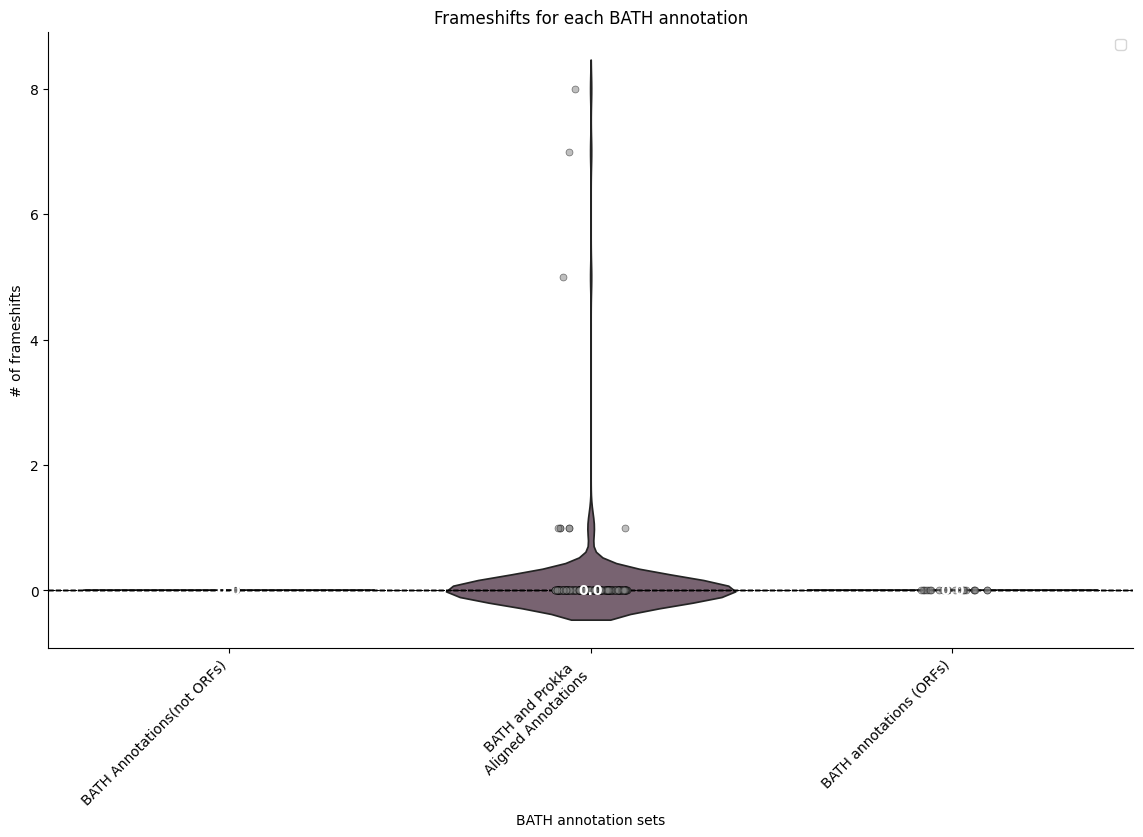

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('default')
fig, ax = plt.subplots(figsize=(14, 8))

palette = {
    'Prokka Unannotated': '#E9C46A',
    'Prokka Annotated ': '#264653',
    'BATH and Prokka Annotated': '#7C5F72',
    'BATH and Prokka Unannotated': '#F4A261',
    'BATH': '#E76F51'
}

sns.violinplot(x='label', y='shifts', data=frameshifts, inner=None, palette=palette, ax=ax)
sns.stripplot(x='label', y='shifts', data=frameshifts, color='grey', edgecolor='black', linewidth=0.5, ax=ax, alpha=0.5)

# Calculate and plot median and quartiles
medians = frameshifts.groupby(['label'])['shifts'].median()
quartiles = frameshifts.groupby(['label'])['shifts'].quantile([0.25, 0.75]).unstack()

for idx, median in enumerate(medians):
    plt.axhline(median, color='black', linestyle='--', linewidth=1)
    plt.text(idx, median, f'{median:.1f}', ha='center', va='center', color='white', fontweight='bold')

for idx, quartile in enumerate(quartiles.itertuples(index=False, name=None)):
    plt.axhline(quartile[0], color='black', linestyle='--', linewidth=0.5)
    plt.axhline(quartile[1], color='black', linestyle='--', linewidth=0.5)

custom_labels = ['BATH Annotations(not ORFs)','BATH and Prokka \n Aligned Annotations','BATH annotations (ORFs)']
ax.set_xticklabels(custom_labels, rotation=45, ha='right')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)  # Ensure bottom line is visible
ax.spines['left'].set_visible(True)
ax.set_title('Frameshifts for each BATH annotation')
ax.set_xlabel('BATH annotation sets')
ax.set_ylabel('# of frameshifts')

plt.legend()
plt.show()
